### extract rel power bands from continuous data
created: 20200723  
Purpose: mostly testing kremen 2018 script

In [16]:
%matplotlib inline

# general use
import numpy as np
import h5py
from tqdm import tqdm
import scipy as sp

# plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
flatui = ["#417CA7", "#D93A46", "#2ecc71", "#ff9408", "#6a79f7", "#f075e6"]
sns.set_palette(sns.color_palette(flatui))

# custom functions here
import sys
sys.path.append("/Users/sunh20/School/Research/sleep_class/scripts/")
import filtering_tools as filt


In [62]:
# import data

filename = "a0f66459_d6_continuous_labeled.h5"
fin = h5py.File(filename, "r")
print(list(fin.keys()))

# the t variable isn't right...i messed up somewhere

chan = fin.get('chan')
data_labels = fin.get('data_labels')
data_neuro = fin.get('data_neuro')
fs = 500
t = np.linspace(0,len(data_neuro)/500,len(data_neuro))

print('data_neuro: ', data_neuro.shape)
print('hours of data: %.2f' % (len(data_neuro)/fs/60/60))

['chan', 'data_labels', 'data_neuro', 't']
data_neuro:  (20519500, 63)
hours of data: 11.40


Text(0.5, 1.0, 'wake = 1, sleep = 0')

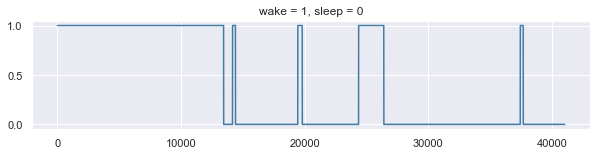

In [50]:
plt.figure(figsize=[10,2])
plt.plot(t,data_labels)
plt.title('wake = 1, sleep = 0')

In [64]:
# split into 30-s epochs

n_epochs = int(np.floor(len(data_neuro)/fs/30))

data_neuro_cut = data_neuro[:n_epochs*fs,:].T # round to nearest 30-s



ValueError: cannot reshape array of size 43060500 into shape ()

In [102]:
# cut to 30-second segments

n_epochs = int(np.floor(len(data_neuro)/fs/30))

# cut neuro
data_neuro_cut = data_neuro[:n_epochs*30*fs,:].T # round to nearest 30-s
data_neuro_ep = np.reshape(data_neuro_cut,(63, -1, 30*fs))

# cut labels
data_labels_ep = np.zeros(n_epochs)
for i in range(n_epochs):
    data_labels_ep[i] = data_labels_temp[i,:].mean().round()
    
print(data_neuro_ep.shape)
print(data_labels_ep.shape)

(63, 1367, 15000)
(1367,)


#### filter exactly in kremen 2018
relative spectral power bands (n=8) with 6th order butterworth, zero-phase 
**power bands:**
- 0.1 - 4
- 4 - 8
- 8 - 13
- 13 - 30
- 30 - 55
- 65 - 115
- 125 - 175
- 185 - 235


abs power in band:  226.63880839247958


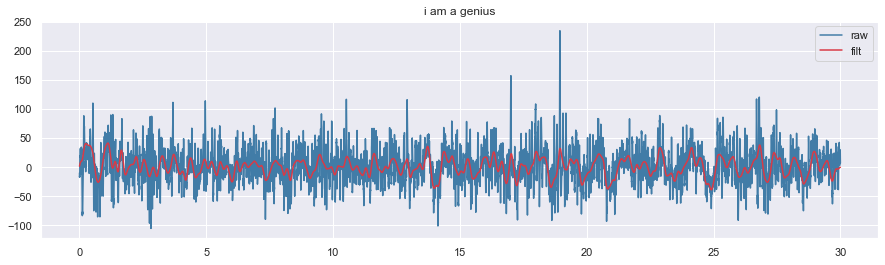

In [150]:
# flex filter example

sig = data_neuro_ep[0,0,:]
sig_filt = filt.flex_filter(sig, fs, f_cut=0.1, f_cut2=4, btype='bandpass', order=6)

plt.figure(figsize=[15,4])
plt.plot(np.linspace(0,30,30*fs),sig,label='raw')
plt.plot(np.linspace(0,30,30*fs),sig_filt,label='filt')
plt.legend()
plt.title('i am a genius');

# power = mean of sqaured power
print('abs power in band: ', str(np.square(sig_filt).mean()))

In [139]:
# filter all epochs

pwbs = [[0.1,4],[4,8],[8,13],[13,30],[30,55],[65,115],[125,175],[185,235]]

data_neuro_pwb_abs = np.zeros((63,n_epochs,8))

for ep in tqdm(range(n_epochs)):
    for ch in range(63):
        sig = data_neuro_ep[ch,ep,:]
        
        for i in range(len(pwbs)):
            low = pwbs[i][0]
            high = pwbs[i][1]
            
            data_neuro_pwb_abs[ch,ep,i] = np.square(filt.flex_filter(sig, fs, f_cut=low, f_cut2=high, btype='bandpass', order=6)).mean()
            
        
np.save('data_neuro_pwb_abs.npy',data_neuro_pwbs_abs)


100%|██████████| 1367/1367 [01:47<00:00, 12.70it/s]


In [149]:
data_neuro_pwb_abs[0,0,0]

1.5986828112322664